In [21]:
import numpy as np
import os
import cv2
from insightface.app import FaceAnalysis
from glob import glob
from insightface.app.common import Face
from insightface.model_zoo import model_zoo
from tqdm import tqdm
from collections import defaultdict
from PIL import Image
from IPython.display import display, Image

In [22]:
det_model_path = 'buffalo_s/det_500m.onnx'
rec_model_path = 'buffalo_s/w600k_mbf.onnx'

det_model = model_zoo.get_model(f'/Users/tayamayuto/Face_recognition_IF/.insightface/models/{det_model_path}')
rec_model = model_zoo.get_model(f'/Users/tayamayuto/Face_recognition_IF/.insightface/models/{rec_model_path}')

det_model.prepare(ctx_id=0, input_size=(640, 640), det_thres=0.5)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}


In [23]:
known_names = []
known_embeddings = []

players = os.listdir('/Users/tayamayuto/Face_recognition_IF/data/ts_raw')

for player in tqdm(players):
    player_embeddings, player_names = [], []

    img_paths = glob(f'/Users/tayamayuto/Face_recognition_IF/data/ts_raw/{player}/*')
    for img_path in img_paths:
        img = cv2.imread(img_path)
        if img is None: continue

        bboxes, kpss = det_model.detect(img, max_num=0, metric='defualt')
        if len(bboxes) != 1: continue

        bbox = bboxes[0, :4]
        det_score = bboxes[0, 4]
        kps = kpss[0]
        face = Face(bbox=bbox, kps=kps, det_score=det_score)

        rec_model.get(img, face)
        player_embeddings.append(face.normed_embedding)
        player_names.append(player)
        if len(player_embeddings) == 10: break

    player_embeddings = np.stack(player_embeddings, axis=0)
    known_embeddings.append(player_embeddings)
    known_names += player_names
    

known_embeddings = np.concatenate(known_embeddings, axis=0)

 59%|█████▊    | 299/510 [03:21<02:47,  1.26it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
 84%|████████▍ | 430/510 [04:51<00:57,  1.40it/s]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
100%|██████████| 510/510 [05:45<00:00,  1.48it/s]


In [24]:
def get_averages(names, scores):
    d = defaultdict(list)
    for n, s in zip(names, scores):
        d[n].append(s)

    averages = {}
    for n, s in d.items():
        averages[n] = np.mean(s)
    
    return averages

In [25]:
def search_average(known_embeddings, known_names, unknown_embeddings, threshold):
    pred_names = []
    for emb in unknown_embeddings:
        scores = np.dot(emb, known_embeddings.T)
        scores = np.clip(scores, 0., 1.)

        averages = get_averages(known_names, scores)
        pred = sorted(averages, key=lambda x: averages[x], reverse=True)[0]
        score = averages[pred]

        if score > threshold:
            pred_names.append(pred)
        else:
            pred_names.append(None)
    
    return pred_names

In [26]:
def draw_on(img, faces, name):
    dimg = img.copy()
    for i in range(len(faces)):
        face = faces[i]
        box = face.bbox.astype(int)
        color = (0, 0, 255)
        cv2.rectangle(dimg, (box[0], box[1]), (box[2], box[3]), color, 2)
        if face.kps is not None:
            kps = face.kps.astype(int)
            #print(landmark.shape)
            for l in range(kps.shape[0]):
                color = (0, 0, 255)
                if l == 0 or l == 3:
                    color = (0, 255, 0)
                cv2.circle(dimg, (kps[l][0], kps[l][1]), 1, color, 2)
        cv2.putText(dimg, name[i], (box[0]-1, box[1]-4),cv2.FONT_HERSHEY_COMPLEX,1.5,(0,255,0),2)

    return dimg

In [27]:
img_path = '/Users/tayamayuto/Face_recognition_IF/data/input/St_re.jpg'
img = cv2.imread(img_path)

app = FaceAnalysis()
app.prepare(ctx_id=0, det_size=(640, 640))

faces = app.get(np.array(img))

unknown_embeddings = []
for i in range(len(faces)):
    unknown_embeddings.append(faces[i].embedding)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /Users/tayamayuto/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3,

In [31]:
pred_names = search_average(known_embeddings, known_names, unknown_embeddings, threshold=0.7)

In [32]:
detect = draw_on(img, faces, pred_names)

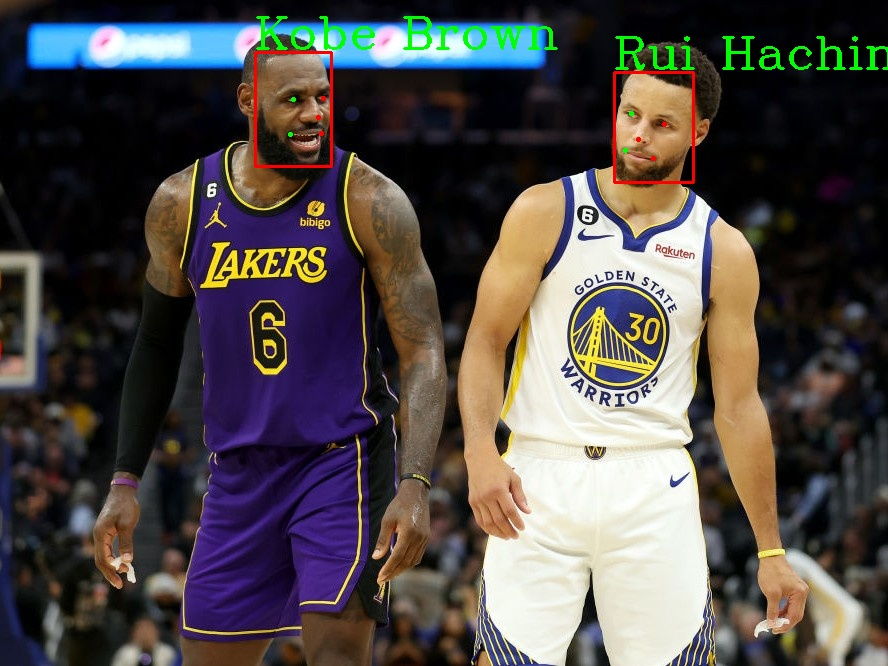

In [33]:
_, buf = cv2.imencode(".jpg", detect)
display(Image(data=buf.tobytes()))